In [1]:

from IPython.display import Image

image_url = 'https://media.geeksforgeeks.org/wp-content/uploads/20200429201549/Inceptionv1_architecture.png'
print("Google Net architecture")
Image(url=image_url,height=1000)


Google Net architecture


## With Tensorflow Keras

In [ ]:
import numpy as np
import keras
import tensorflow as tf
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10
from keras.layers import Conv2D, MaxPool2D,Dropout, Dense, Input, concatenate, GlobalAveragePooling2D, AveragePooling2D,Flatten,  Average
import tensorflow_datasets as tfds

## Inception Module

In [ ]:
class InceptionModule(keras.Model):
    def __init__(self, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj, name=None):
        super().__init__()
        self.conv_1x1 = Conv2D(filters_1x1, (1,1), padding="same", activation="relu")
        self.conv_3x3_red = Conv2D(filters_3x3_reduce, (3,3), padding="same", activation="relu")
        self.conv_3x3 = Conv2D(filters_3x3, (3,3), padding="same", activation="relu")
        self.conv_5x5_red = Conv2D(filters_5x5_reduce, (5,5), padding="same", activation="relu")
        self.conv_5x5 = Conv2D(filters_5x5, (5,5), padding="same", activation="relu")
        self.pool_proj_red = MaxPool2D((3,3), strides=(1,1), padding="same")
        self.pool = Conv2D(filters_pool_proj, (1,1), padding="same", activation="relu")
        self.name = name
    
    def call(self, X):
        conv_1 = self.conv_1x1(X)
        conv_3_red = self.conv_3x3_red(X)
        conv_3 = self.conv_3x3(conv_3_red)
        conv_5_red = self.conv_5x5_red(X)
        conv_5 = self.conv_5x5(conv_5_red)
        pool_red = self.pool_proj_red(X)
        pool = self.pool(pool_red)
        output = concatenate([conv_1, conv_3, conv_5, pool], axis=3, name = self.name)
        return output          

## Test InceptionModule

In [ ]:
inception_module = InceptionModule(
    filters_1x1=64,
    filters_3x3_reduce=96,
    filters_3x3=128,
    filters_5x5_reduce=16,
    filters_5x5=32,
    filters_pool_proj=32,
    name="inception_block_1"
)

input_tensor = keras.Input(shape=(224, 224, 3))

output_tensor = inception_module(input_tensor)
print(output_tensor)

In [ ]:
inception_module.summary()

## Google Net architecture

In [ ]:
class GoogLeNet(keras.Model):
    def __init__(self, num_classes):
        super(GoogLeNet, self).__init__()
        
        
        self.conv_1_7x7 = Conv2D(64, (7,7),   padding="same", strides=(2,2), activation="relu")
        self.max_pool_1 = MaxPool2D((3,3),    padding="same", strides=(2,2))
        self.conv_2_1x1 = Conv2D(64, (1,1),   padding="same", strides=(1,1), activation="relu")
        self.conv_3_3x3 = Conv2D(192, (3,3),  padding="same", strides=(1,1), activation="relu")
        self.max_pool_2 = MaxPool2D((3,3),    padding="same", strides=(2,2))
        
        self.inception_1 = InceptionModule(filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128,filters_5x5_reduce=16, filters_5x5=32,filters_pool_proj=32, name="inception_3a")
        self.inception_2 = InceptionModule(filters_1x1=128,filters_3x3_reduce=128, filters_3x3=192,filters_5x5_reduce=32,  filters_5x5=96,filters_pool_proj=64,  name="inception_3b")
        
        self.max_pool_3 = MaxPool2D((3,3), padding="same", strides = (2,2))
        
        self.inception_3 = InceptionModule(filters_1x1=192,filters_3x3_reduce=96, filters_3x3=208,filters_5x5_reduce=16,filters_5x5=48,filters_pool_proj=64,  name="inception_4a")
        
        self.flatten =  Flatten()
        
        # Output 1
        self.x1_avg = AveragePooling2D((5,5), strides=3)
        self.x1_conv = Conv2D(128, (1,1), padding="same", activation="relu")
        self.x1_dense1 = Dense(1024, activation="relu")
        self.x1_drop = Dropout(0.7)
        self.x1_out = Dense(num_classes, activation="softmax")
        
        self.inception_4 = InceptionModule(filters_1x1=160,filters_3x3_reduce=112, filters_3x3=224,filters_5x5_reduce=24,filters_5x5=64, filters_pool_proj=64,name="inception_4b")
        self.inception_5 = InceptionModule(filters_1x1=128,filters_3x3_reduce=128, filters_3x3=256,filters_5x5_reduce=24,filters_5x5=64, filters_pool_proj=64,name="inception_4c")
        self.inception_6 = InceptionModule(filters_1x1=112,filters_3x3_reduce=144, filters_3x3=288,filters_5x5_reduce=32,filters_5x5=64, filters_pool_proj=64,  name="inception_4d")
        
        self.x2_avg = AveragePooling2D((5,5), strides=3)
        self.x2_conv = Conv2D(128,(1,1), padding="same", activation="relu")
        self.x2_dense1 = Dense(1024, activation="relu")
        self.x2_drop = Dropout(0.7)
        self.x2_out = Dense(num_classes, activation="softmax")
        
        self.inception_7 = InceptionModule(filters_1x1=256,filters_3x3_reduce=160, filters_3x3=320,filters_5x5_reduce=32,filters_5x5=128,  filters_pool_proj=128,  name="inception_4e")
        
        self.max_pool_4 = MaxPool2D((3,3), padding="same", strides=(2,2))
        
        self.inception_8 = InceptionModule(filters_1x1=256,filters_3x3_reduce=160, filters_3x3=320,filters_5x5_reduce=32,filters_5x5=128,  filters_pool_proj=128,  name="inception_5a")
        self.inception_9 = InceptionModule(filters_1x1=384,filters_3x3_reduce=192, filters_3x3=384,filters_5x5_reduce=48,filters_5x5=128, filters_pool_proj=128, name="inception_5b")
        
        self.x3_avg = GlobalAveragePooling2D()
        self.x3_drop = Dropout(0.3)
        self.x3_out = Dense(num_classes, activation="softmax")
        
        self.avg_out = Average()
        
    def call(self, X):
            
        X = self.conv_1_7x7(X)
        X = self.max_pool_1(X)
        X = self.conv_2_1x1(X)
        X = self.conv_3_3x3(X)
        X = self.max_pool_2(X)
        
        X = self.inception_1(X)
        X = self.inception_2(X)
        X = self.max_pool_3(X)
        X = self.inception_3(X)
        
        X1 = self.x1_avg(X)
        X1 = self.x1_conv(X1)
        X1 = self.flatten(X1)
        X1 = self.x1_dense1(X1)
        X1 = self.x1_drop(X1)
        X1 = self.x1_out(X1)
        
        X = self.inception_4(X)
        X = self.inception_5(X)
        X = self.inception_6(X)
        
        X2 = self.x2_avg(X)
        X2 = self.x2_conv(X2)
        X2 = self.flatten(X2)
        X2 = self.x2_dense1(X2)
        X2 = self.x2_drop(X2)
        X2 = self.x2_out(X2)
                                 
        X = self.inception_7(X)
        X = self.inception_8(X)
        X = self.max_pool_4(X)
        X = self.inception_9(X)
        
        X = self.x3_avg(X)
        X = self.x3_drop(X)
        X = self.x3_out(X)
        out = self.avg_out([X, X1, X2])
        return   out

## Test GoogLeNet

In [ ]:
google_net = GoogLeNet(10)

input_tensor = keras.Input(shape=(224, 224, 3))

output_tensor = google_net(input_tensor)
print(output_tensor)

In [ ]:
google_net.summary()

## Train with cats_vs_dogs dataset

In [ ]:
dataset = tfds.load('cats_vs_dogs', split='train[:70%]', as_supervised=True)

train_dataset = dataset.take(int(len(dataset) * 0.8))
test_dataset = dataset.skip(int(len(dataset) * 0.8))


def preprocess(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dataset = train_dataset.map(preprocess).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_dataset = train_dataset.batch(batch_size=32)

In [ ]:
num_classes = 2
input_shape = (224,224,3)

In [ ]:
model = GoogLeNet(num_classes)

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.fit(train_dataset, epochs=10)

## With Pytorch

In [2]:
import gc
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchview import draw_graph
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

##  Inception Module

In [4]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
        super(InceptionModule, self).__init__()
        self.conv_1x1 = nn.Conv2d(in_channels, filters_1x1, kernel_size=1)
        self.conv_3x3_red = nn.Conv2d(in_channels, filters_3x3_reduce, kernel_size=1)
        self.conv_3x3 = nn.Conv2d(filters_3x3_reduce, filters_3x3, kernel_size=3, padding=1)
        self.conv_5x5_red = nn.Conv2d(in_channels, filters_5x5_reduce, kernel_size=1)
        self.conv_5x5 = nn.Conv2d(filters_5x5_reduce, filters_5x5, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.pool_proj = nn.Conv2d(in_channels, filters_pool_proj, kernel_size=1)

    def forward(self, x):
        conv_1 = F.relu(self.conv_1x1(x))
        conv_3_red = F.relu(self.conv_3x3_red(x))
        conv_3 = F.relu(self.conv_3x3(conv_3_red))
        conv_5_red = F.relu(self.conv_5x5_red(x))
        conv_5 = F.relu(self.conv_5x5(conv_5_red))
        pool = F.relu(self.pool_proj(self.pool(x)))
        output = torch.cat([conv_1, conv_3, conv_5, pool], dim=1)
        return output

In [5]:
x = torch.randn(1,3,224,224)
model = InceptionModule(3, 64, 96, 128, 16, 32, 32)
print('InceptionModule Output shape : ',model(x).shape)

InceptionModule Output shape :  torch.Size([1, 256, 224, 224])


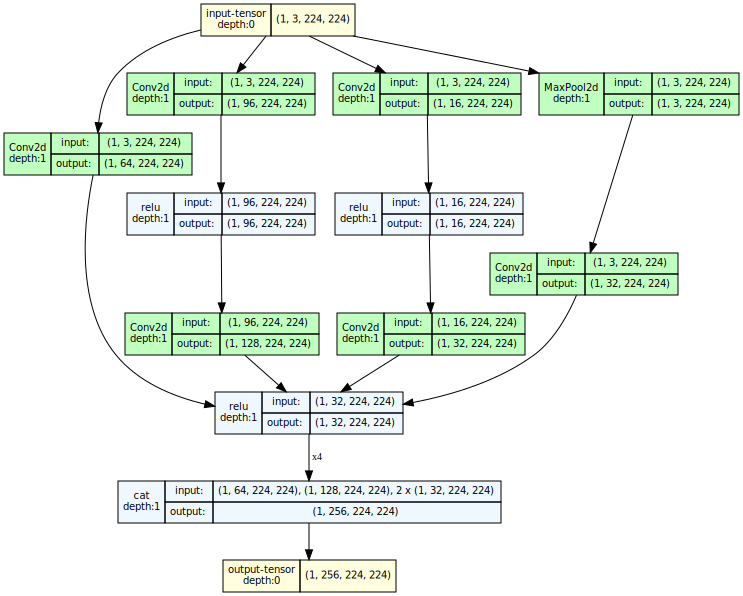

In [6]:
architecture = 'InceptionModule'
model_graph = draw_graph(model, input_size=(1,3,224,224), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
model_graph.visual_graph

## GoogLeNet 

In [7]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=2):
        super(GoogLeNet, self).__init__()
        
        # Initial Convolution and Pooling
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        self.conv3 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Inception Modules
        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception5a = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)
        
        # Auxiliary Classifier 1
        self.aux1_avgpool = nn.AvgPool2d(kernel_size=5, stride=3, padding=2)
        self.aux1_conv = nn.Conv2d(512, 128, kernel_size=1)
        self.aux1_fc1 = nn.Linear(128 * 5 * 5, 128)
        self.aux1_drop = nn.Dropout(p=0.7)
        self.aux1_fc2 = nn.Linear(128, num_classes)
        
        # Auxiliary Classifier 2
        self.aux2_avgpool = nn.AvgPool2d(kernel_size=5, stride=3, padding=2)
        self.aux2_conv = nn.Conv2d(528, 128, kernel_size=1)
        self.aux2_fc1 = nn.Linear(128 * 5 * 5, 128)
        self.aux2_drop = nn.Dropout(p=0.7)
        self.aux2_fc2 = nn.Linear(128, num_classes)
        
        # Final Classifier
        self.final_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.final_drop = nn.Dropout(p=0.3)
        self.final_fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.maxpool2(x)
        
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)
        
        # Auxiliary Classifier 1
        x1 = self.aux1_avgpool(x)
        x1 = F.relu(self.aux1_conv(x1))
        x1 = torch.flatten(x1, 1)
        x1 = F.relu(self.aux1_fc1(x1))
        x1 = self.aux1_drop(x1)
        x1 = self.aux1_fc2(x1)
        
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        
        # Auxiliary Classifier 2
        x2 = self.aux2_avgpool(x)
        x2 = F.relu(self.aux2_conv(x2))
        x2 = torch.flatten(x2, 1)
        x2 = F.relu(self.aux2_fc1(x2))
        x2 = self.aux2_drop(x2)
        x2 = self.aux2_fc2(x2)
        
        x = self.inception5a(x)
        x = self.inception5b(x)
        
        # Final Classifier
        x3 = self.final_avgpool(x)
        x3 = torch.flatten(x3, 1)
        x3 = self.final_drop(x3)
        x3 = self.final_fc(x3)
        out = (x1+x2+x3)/3
        return out

## Checking model

In [8]:
model = GoogLeNet(num_classes=2)
input_tensor = torch.rand((1, 3, 224, 224)) 
print('GoogLeNet Output shape : ',model(input_tensor).shape)

GoogLeNet Output shape :  torch.Size([1, 2])


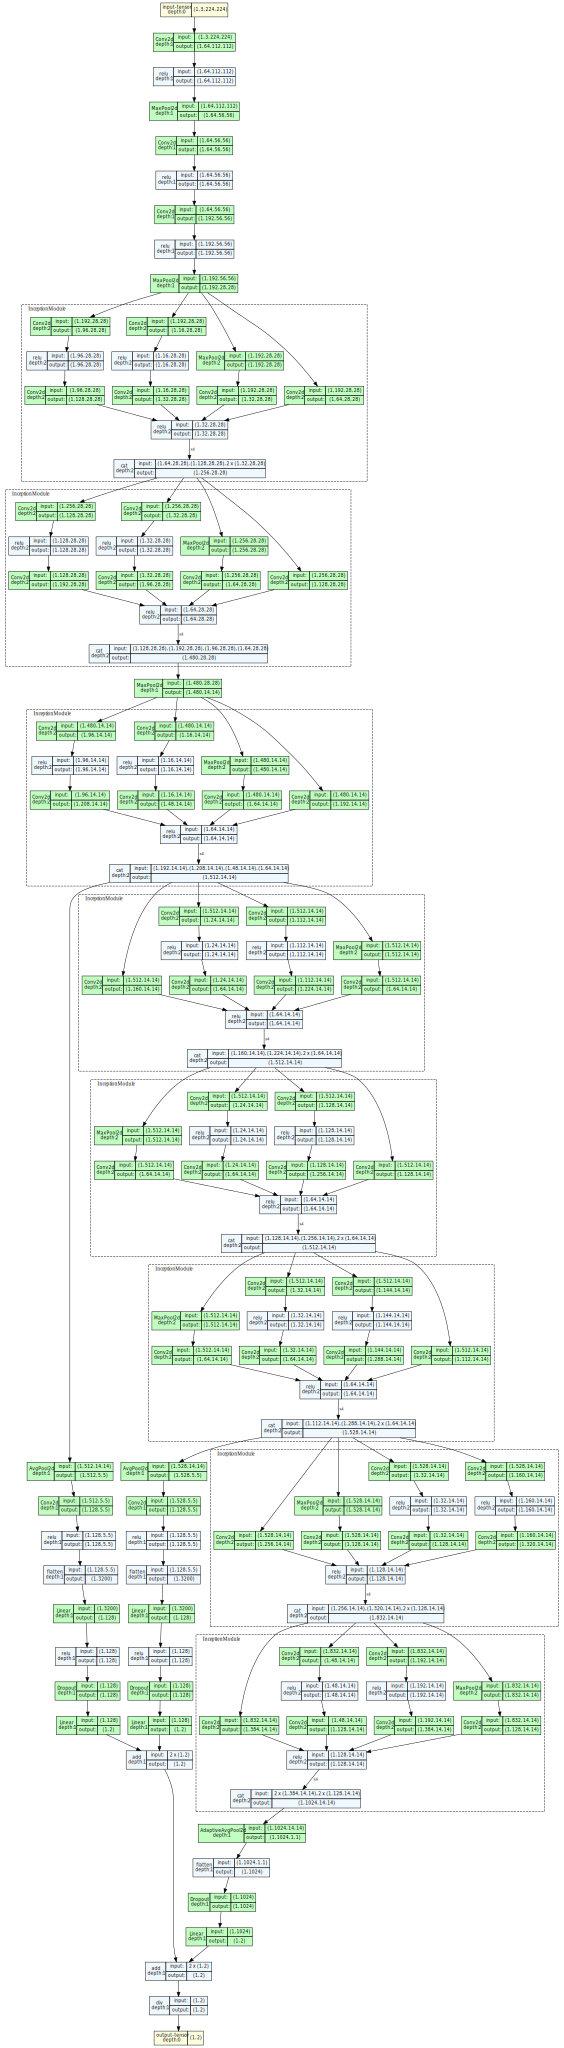

In [9]:
architecture = 'GoogLeNet'
model_graph = draw_graph(model, input_size=(1,3,224,224), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
model_graph.visual_graph

## Total parameters

In [10]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 5885494


## Loading train, test and valid data

In [27]:
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=data_transforms)


train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified


## Hyperparameters, optimizer and criterion

In [28]:
num_classes = 100
num_epochs = 10
learning_rate = 0.0001


model = GoogLeNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.001) 

## Trainig model

In [30]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
    
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print (f"Epoch [{epoch+1}/{num_epochs}]\tLoss: {loss.item():.4f}", end="\t")
    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
    print(f"valid accuracy : {correct / total}") 

Epoch [1/10]	Loss: 4.6053	valid accuracy : 0.0104
Epoch [2/10]	Loss: 4.6034	valid accuracy : 0.0116
Epoch [3/10]	Loss: 4.6101	valid accuracy : 0.012
Epoch [4/10]	Loss: 4.6088	valid accuracy : 0.012
Epoch [5/10]	Loss: 4.6030	valid accuracy : 0.012
Epoch [6/10]	Loss: 4.6069	valid accuracy : 0.012
Epoch [7/10]	Loss: 4.6095	valid accuracy : 0.012
Epoch [8/10]	Loss: 4.6073	valid accuracy : 0.0088
Epoch [9/10]	Loss: 4.6043	valid accuracy : 0.008
Epoch [10/10]	Loss: 4.6046	valid accuracy : 0.008


## Testing model

In [31]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs
    
print(f"Accuracy of test images : {100 * correct / total} %") 

Accuracy of test images : 0.74 %
